In [1]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
import keras
from keras.initializers import he_normal
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, MaxPooling1D, Flatten, Embedding, Input
from keras.layers.convolutional import Conv1D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard, EarlyStopping
from tensorboard.plugins.pr_curve import summary as pr_summary

%matplotlib inline

/Users/tim/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Data Exploration

In [2]:
X_dataset = '../../datasets/powertrain/pt_20K_uniform_samples_X.csv'
y_dataset = '../../datasets/powertrain/pt_20K_uniform_samples_T.csv'

In [2]:
X_dataset = '../../datasets/powertrain/pt_100K_uniform_samples_X.csv'
y_dataset = '../../datasets/powertrain/pt_100K_uniform_samples_T.csv'

In [3]:
X = pd.read_csv(X_dataset, index_col=0, header=None).T
y = pd.read_csv(y_dataset, index_col=0, header=None).T

In [4]:
# Normalize
X = X.apply(zscore)
(num_samples, num_features) = X.shape
print (num_samples, num_features)

(19999, 7)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x121f0c550>,
      dtype=object)

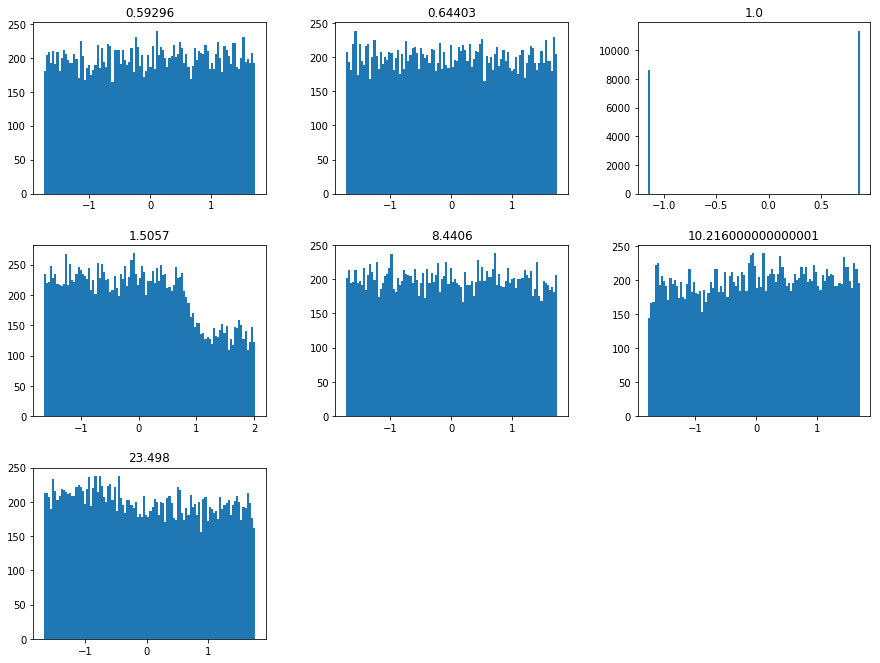

In [5]:
X.hist(grid=False, figsize=(15,40), layout=(10,3), bins=100, sharex=False)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x121f0c490>]],
      dtype=object)

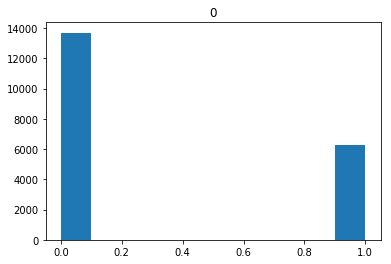

In [6]:
y.hist(grid=False)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True)

# TensorBoard Visualization

Displays Precision-Recall curve for Keras models.

Adapted from: https://medium.com/@akionakas/precision-recall-curve-with-keras-cd92647685e1

In [8]:
class PRTensorBoard(TensorBoard):
    def __init__(self, *args, **kwargs):
        # One extra argument to indicate whether or not to use the PR curve summary.
        self.pr_curve = kwargs.pop('pr_curve', True)
        super(PRTensorBoard, self).__init__(*args, **kwargs)

        global tf
        import tensorflow as tf

    def set_model(self, model):
        super(PRTensorBoard, self).set_model(model)

        if self.pr_curve:
            # Get the prediction and label tensor placeholders.
            predictions = self.model._feed_outputs[0]
            labels = tf.cast(self.model._feed_targets[0], tf.bool)
            # Create the PR summary OP.
            self.pr_summary = pr_summary.op(name='pr_curve',
                                            predictions=predictions,
                                            labels=labels,
                                            display_name='Precision-Recall Curve')

    def on_epoch_end(self, epoch, logs=None):
        super(PRTensorBoard, self).on_epoch_end(epoch, logs)

        if self.pr_curve and self.validation_data:
            # Get the tensors again.
            tensors = self.model._feed_targets + self.model._feed_outputs
            # Predict the output.
            predictions = self.model.predict(self.validation_data[0])
            # Build the dictionary mapping the tensor to the data.
            val_data = [self.validation_data[1], predictions]
            feed_dict = dict(zip(tensors, val_data))
            # Run and add summary.
            result = self.sess.run([self.pr_summary], feed_dict=feed_dict)
            self.writer.add_summary(result[0], epoch)
        self.writer.flush()

# DNN

In [13]:
epochs = 100
batch_size = 32

model = Sequential()
model.add(Dense(128, input_dim=num_features))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(1))
model.add(Activation('sigmoid'))

In [14]:
opt = keras.optimizers.Adagrad()

model.compile(loss = 'binary_crossentropy',
              optimizer = opt,
              metrics = ['accuracy'])

In [15]:
model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=.2,
          shuffle=True,
          callbacks=[EarlyStopping(monitor='val_acc', patience=2)])

Train on 12799 samples, validate on 3200 samples
Epoch 1/100
12799/12799 [==============================] - 1s 115us/step - loss: 0.2524 - acc: 0.8697 - val_loss: 0.2038 - val_acc: 0.8841
Epoch 2/100
12799/12799 [==============================] - 1s 88us/step - loss: 0.2092 - acc: 0.8919 - val_loss: 0.1932 - val_acc: 0.9178
Epoch 3/100
12799/12799 [==============================] - 1s 83us/step - loss: 0.1986 - acc: 0.9016 - val_loss: 0.1882 - val_acc: 0.9281
Epoch 4/100
12799/12799 [==============================] - 1s 84us/step - loss: 0.1899 - acc: 0.9095 - val_loss: 0.1759 - val_acc: 0.9322
Epoch 5/100
12799/12799 [==============================] - 1s 84us/step - loss: 0.1825 - acc: 0.9191 - val_loss: 0.1688 - val_acc: 0.9347
Epoch 6/100
12799/12799 [==============================] - 1s 85us/step - loss: 0.1830 - acc: 0.9192 - val_loss: 0.1624 - val_acc: 0.9363
Epoch 7/100
12799/12799 [==============================] - 1s 84us/step - loss: 0.1738 - acc: 0.9240 - val_loss: 0.1569 - 

In [16]:
score = model.evaluate(X_test, y_test, batch_size=batch_size)
print model.metrics_names
print score

4000/4000 [==============================] - 0s 41us/step
['loss', 'acc']
[0.1364285856485367, 0.94325]


# CNN Model

In [17]:
epochs = 100
batch_size = 32
X_train_cnn = np.expand_dims(X_train.as_matrix(), axis=2)
X_test_cnn = np.expand_dims(X_test.as_matrix(), axis=2)

In [31]:
inputs = Input(shape=(num_features, 1))
conv1 = Conv1D(32, 3, padding='same', strides=1, kernel_initializer=he_normal(seed=None))(inputs)
relu1 = Activation('relu')(conv1)

conv2 = Conv1D(16, 3, padding='same', strides=1, kernel_initializer=he_normal(seed=None))(relu1)
relu2 = Activation('relu')(conv2)
flatten = Flatten()(relu2)

fc1 = Dense(128, kernel_initializer=he_normal(seed=None))(flatten)
relu2 = Activation('relu')(fc1)
drop1 = Dropout(0.5)(relu2)

fc2 = Dense(64, kernel_initializer=he_normal(seed=None))(drop1)
relu3 = Activation('relu')(fc2)
drop2 = Dropout(0.5)(relu3)

fc3 = Dense(1)(drop2)
outputs = Activation('sigmoid')(fc3)

model = Model(inputs=inputs, outputs=outputs)

In [32]:
opt = keras.optimizers.Adagrad()

model.compile(loss = 'binary_crossentropy',
              optimizer = opt,
              metrics = ['accuracy'])

In [ ]:
model.fit(X_train_cnn, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=.2,
          shuffle=True,
          callbacks=[EarlyStopping(monitor='val_acc', patience=6)])

Train on 12799 samples, validate on 3200 samples
Epoch 1/100
12799/12799 [==============================] - 3s 246us/step - loss: 0.2449 - acc: 0.8834 - val_loss: 0.1854 - val_acc: 0.9137
Epoch 2/100
12799/12799 [==============================] - 2s 155us/step - loss: 0.1893 - acc: 0.9151 - val_loss: 0.1630 - val_acc: 0.9272
Epoch 3/100
12799/12799 [==============================] - 2s 174us/step - loss: 0.1681 - acc: 0.9259 - val_loss: 0.1557 - val_acc: 0.9300
Epoch 4/100
12799/12799 [==============================] - 2s 167us/step - loss: 0.1623 - acc: 0.9295 - val_loss: 0.1456 - val_acc: 0.9406
Epoch 5/100
12799/12799 [==============================] - 2s 161us/step - loss: 0.1553 - acc: 0.9298 - val_loss: 0.1395 - val_acc: 0.9419
Epoch 6/100
12799/12799 [==============================] - 2s 147us/step - loss: 0.1468 - acc: 0.9369 - val_loss: 0.1369 - val_acc: 0.9409
Epoch 7/100
12799/12799 [==============================] - 2s 183us/step - loss: 0.1421 - acc: 0.9391 - val_loss: 0.1

In [30]:
score = model.evaluate(X_test_cnn, y_test, batch_size=batch_size)
print model.metrics_names
print score

4000/4000 [==============================] - 0s 52us/step
['loss', 'acc']
[0.10220321153104306, 0.95875]
